In [57]:
import pandas as pd
import numpy as np
from datetime import datetime

## Patients (village_emr_patients.csv)

This file contains de-identified demographic details for each patient in the system.  

**Key fields:**
- **patient_id** — Unique identifier for each patient 
- **first_name, last_name**
- **dob** — Date of birth  
- **sex** — Reported sex of the patient  
- **primary_payer** — Primary insurance (e.g., Medicaid, Medicare, BCBS, Self-Pay)  
- **city** — Patient’s home city

In [58]:
patients = pd.read_csv('village_emr_patients.csv', parse_dates=['dob'])

patients.head()

,patient_id,first_name,last_name,dob,sex,primary_payer,city
0,1,Pat1,L1,1996-11-08,M,Medicaid,West Fargo
1,2,Pat2,L2,1968-03-22,F,Sanford,Casselton
2,3,Pat3,L3,1982-02-21,M,Sanford,Horace
3,4,Pat4,L4,1993-11-27,F,Medicaid,Dilworth
4,5,Pat5,L5,1959-03-12,F,Sanford,West Fargo


## Clinicians (village_emr_clinicians.csv)

**Key fields:**
- **clinician_id** — Unique identifier for each clinician
- **clinician_name** — De-identified clinician name  
- **credential** — Professional credential (LCSW, LICSW, LMFT, etc.)  
- **hire_date** — Employment start date  
- **active** — Current employment status flag  
- **location** — Primary work site  

In [59]:
clinicians = pd.read_csv('village_emr_clinicians.csv', parse_dates=['hire_date'])

clinicians.head()

,clinician_id,clinician_name,credential,hire_date,active,location
0,1,Clinician 1,LMFT,2024-04-02,True,Moorhead
1,2,Clinician 2,LICSW,2020-02-25,True,Moorhead
2,3,Clinician 3,LMFT,2024-05-21,True,Fargo - Main
3,4,Clinician 4,LCSW,2021-06-06,True,Grand Forks
4,5,Clinician 5,LPC,2024-06-21,True,Grand Forks


## Encounters (village_emr_encounters.csv)

**Key fields:**
- **encounter_id** — Unique identifier for each encounter
- **encounter_datetime** → **enc_date, month** — Service date/time and derived buckets  
- **patient_id**
- **clinician_id**
- **location** — Clinic site where the service occurred  
- **service_code** — CPT/HCPCS code (e.g., 90791, 90834, 90837, H0031)  
- **duration_min** — Scheduled or actual session duration  
- **status** — Completed, No-Show, Cancelled, Rescheduled  


In [60]:
encounters = pd.read_csv('village_emr_encounters.csv', parse_dates=['encounter_datetime'])

encounters.head()

,encounter_id,encounter_datetime,patient_id,clinician_id,location,service_code,duration_min,status
0,100001,2025-02-13 05:40:00,313,5,Fargo - South,H0031,45,Completed
1,100002,2025-01-10 17:07:00,595,19,Fargo - Main,90791,30,Completed
2,100003,2025-04-17 19:27:00,12,21,Fargo - Main,90837,45,Completed
3,100004,2025-04-06 02:33:00,517,25,Fargo - Main,90834,60,Completed
4,100005,2025-03-28 16:28:00,318,18,Fargo - South,90834,60,Completed


In [61]:
encounters['enc_date'] = encounters['encounter_datetime'].dt.date

encounters.head()

,encounter_id,encounter_datetime,patient_id,clinician_id,location,service_code,duration_min,status,enc_date
0,100001,2025-02-13 05:40:00,313,5,Fargo - South,H0031,45,Completed,2025-02-13
1,100002,2025-01-10 17:07:00,595,19,Fargo - Main,90791,30,Completed,2025-01-10
2,100003,2025-04-17 19:27:00,12,21,Fargo - Main,90837,45,Completed,2025-04-17
3,100004,2025-04-06 02:33:00,517,25,Fargo - Main,90834,60,Completed,2025-04-06
4,100005,2025-03-28 16:28:00,318,18,Fargo - South,90834,60,Completed,2025-03-28


In [62]:
encounters['enc_date'] = pd.to_datetime(encounters['enc_date'])

In [63]:
# adding month column 
encounters['month'] = pd.to_datetime(encounters['enc_date']).dt.to_period('M').astype(str)

In [64]:
encounters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   encounter_id        5000 non-null   int64         
 1   encounter_datetime  5000 non-null   datetime64[ns]
 2   patient_id          5000 non-null   int64         
 3   clinician_id        5000 non-null   int64         
 4   location            5000 non-null   object        
 5   service_code        5000 non-null   object        
 6   duration_min        5000 non-null   int64         
 7   status              5000 non-null   object        
 8   enc_date            5000 non-null   datetime64[ns]
 9   month               5000 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 390.8+ KB


## Billing (village_emr_billing.csv)

This file represents claim/charge-level data tied to encounters.

**Key fields:**
- **encounter_id** 
- **submitted_date** → **month** — Claim submission date and derived bucket  
- **payer** — Payer billed (e.g., Medicaid, Medicare, BCBS, Sanford, Self-Pay)  
- **charge_amount** — Billed charge amount  
- **allowed_amount** — Contracted allowed amount  
- **paid_amount** — Actual payment received  
- **days_to_payment** — Lag from submission to payment  
- **denied_flag / is_denied** — Claim denial indicators  
- **denial_reason** — Reason code (Eligibility, Coding, Authorization, Timely Filing, etc.)  
- **charge_lag_days** — Encounter-to-submission lag (if derived)  
- **net_collection_pct** — `paid_amount / allowed_amount`  

In [65]:
billing = pd.read_csv('village_emr_billing.csv', parse_dates=['submitted_date'])

billing.head()

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason
0,100001,130.0,2025-02-13,Medicaid,95.32,92.34,16.0,False,NaN
1,100002,250.0,2025-01-10,Medicaid,199.54,194.33,21.0,False,NaN
2,100003,200.0,2025-04-22,Sanford,160.28,141.25,25.0,False,NaN
3,100004,160.0,2025-04-10,Medicare,141.37,126.17,24.0,False,NaN
4,100005,160.0,2025-03-28,Sanford,135.16,121.88,38.0,False,NaN


In [66]:
# adding month column
billing['month'] = pd.to_datetime(billing['submitted_date']).dt.to_period('M').astype(str)

In [67]:
billing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896 entries, 0 to 3895
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   encounter_id     3896 non-null   int64         
 1   charge_amount    3896 non-null   float64       
 2   submitted_date   3896 non-null   datetime64[ns]
 3   payer            3896 non-null   object        
 4   allowed_amount   3896 non-null   float64       
 5   paid_amount      3607 non-null   float64       
 6   days_to_payment  3607 non-null   float64       
 7   denied_flag      3896 non-null   bool          
 8   denial_reason    266 non-null    object        
 9   month            3896 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 277.9+ KB


## Credentialing (village_emr_credentialing.csv)

This file tracks clinician paneling/credentialing status with different payers.

**Key fields:**
- **clinician_id**
- **insurer** — Payer/panel (e.g., Medicaid, Medicare, BCBS)  
- **status** — Active, Applied, Expired, Termed  
- **effective_date** — Credential effective date  
- **expiration_date** — Credential expiration date  

In [68]:
credentialing = pd.read_csv('village_emr_credentialing.csv', parse_dates=['effective_date', 'expiration_date'])

credentialing.head()

,clinician_id,insurer,status,effective_date,expiration_date
0,1,Medicaid,Active,2022-02-04,2024-04-01
1,1,Medicare,Active,2022-11-16,2025-04-25
2,1,BCBS,Active,2022-11-11,2024-04-09
3,1,Sanford,Active,2022-01-25,2023-10-19
4,1,Aetna,Active,2022-02-03,2024-08-26


In [69]:
credentialing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   clinician_id     150 non-null    int64         
 1   insurer          150 non-null    object        
 2   status           150 non-null    object        
 3   effective_date   150 non-null    datetime64[ns]
 4   expiration_date  150 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 6.0+ KB


## KPI Targets (village_emr_kpi_targets.csv)

This file defines benchmark targets used to evaluate operational and revenue-cycle KPIs.

**Key fields:**
- **month** — Monthly bucket  
- **target_no_show_rate** — e.g., ≤7%  
- **target_clean_claim_rate** — e.g., ≥90%  
- **target_dso_days** — e.g., ≤35 days  
- **target_charge_lag_days** — e.g., ≤3 days  
- **target_denial_rate** — e.g., ≤6%  

In [70]:
kpi_targets = pd.read_csv("village_emr_kpi_targets.csv")

kpi_targets

,month,target_no_show_rate,target_clean_claim_rate,target_dso_days,target_charge_lag_days,target_denial_rate
0,2025-01,0.07,0.9,35,3,0.06
1,2025-02,0.07,0.9,35,3,0.06
2,2025-03,0.07,0.9,35,3,0.06
3,2025-04,0.07,0.9,35,3,0.06
4,2025-05,0.07,0.9,35,3,0.06
5,2025-06,0.07,0.9,35,3,0.06
6,2025-07,0.07,0.9,35,3,0.06
7,2025-08,0.07,0.9,35,3,0.06


In [71]:
kpi_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   month                    8 non-null      object 
 1   target_no_show_rate      8 non-null      float64
 2   target_clean_claim_rate  8 non-null      float64
 3   target_dso_days          8 non-null      int64  
 4   target_charge_lag_days   8 non-null      int64  
 5   target_denial_rate       8 non-null      float64
dtypes: float64(3), int64(2), object(1)
memory usage: 512.0+ bytes


## 1) Data Quality Checks

### Checking for duplicate data

In [72]:
patients.duplicated().sum()

0

In [73]:
clinicians.duplicated().sum()

0

In [74]:
encounters.duplicated().sum()

0

In [75]:
billing.duplicated().sum()

0

In [76]:
credentialing.duplicated().sum()

0

In [77]:
kpi_targets.duplicated().sum()

0

In [78]:
# referential integrity (encounter_id)
billing[~billing['encounter_id'].isin(encounters['encounter_id'])]

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason,month


In [79]:
# referential integrity (clinician_id)
credentialing[~credentialing['clinician_id'].isin(clinicians['clinician_id'])]

,clinician_id,insurer,status,effective_date,expiration_date


In [80]:
# status distribution
encounters['status'].value_counts(normalize=True).rename_axis('status').reset_index(name='pct')

,status,pct
0,Completed,0.7792
1,Cancelled,0.1024
2,No-Show,0.0784
3,Rescheduled,0.0400


In [81]:
# no show by location
no_show = (encounters.assign(no_show=lambda x: (x['status'] == 'No-Show').astype(int)).
          groupby(['month', 'location'], as_index=False)['no_show'].mean())

no_show = no_show.sort_values(['month', 'no_show'], ascending=[True, False]).copy()

no_show.head()

,month,location,no_show
0,2025-01,Fargo - Main,0.092715
1,2025-01,Fargo - South,0.068027
2,2025-01,Grand Forks,0.064103
3,2025-01,Moorhead,0.050279
7,2025-02,Moorhead,0.097701


## 1) No-Show by location

In [82]:
target_no_show = 0.07

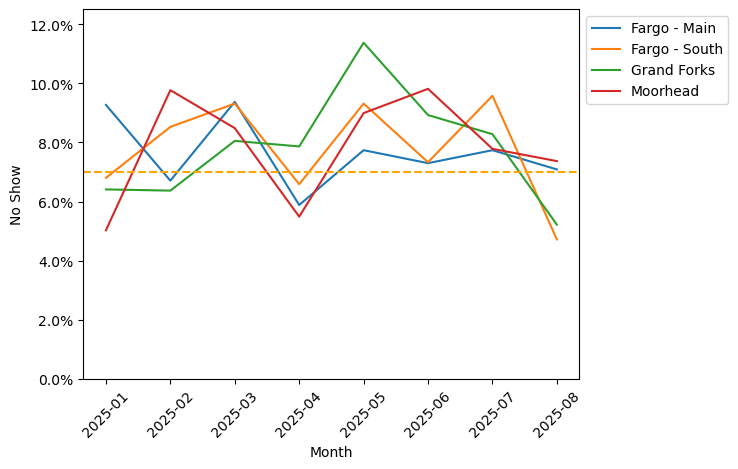

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plot_max = (no_show['no_show'].max() * 1.1)

sns.lineplot(data=no_show, x='month', y='no_show', hue='location')

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('No Show')
plt.xlabel('Month')
plt.axhline(y=target_no_show, linestyle='--', color='orange')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.ylim(0, plot_max)
plt.xticks(rotation=45)
plt.show()

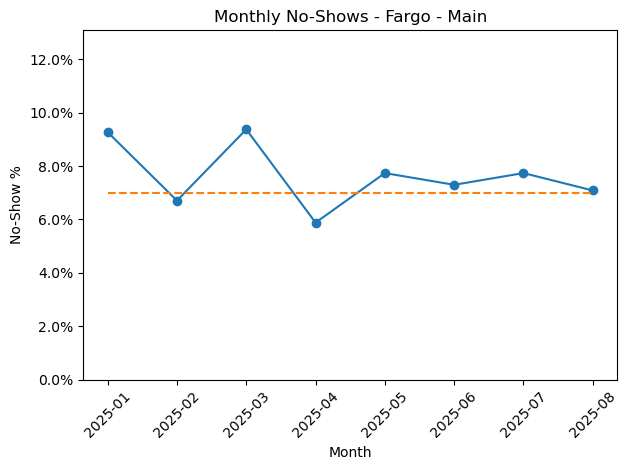

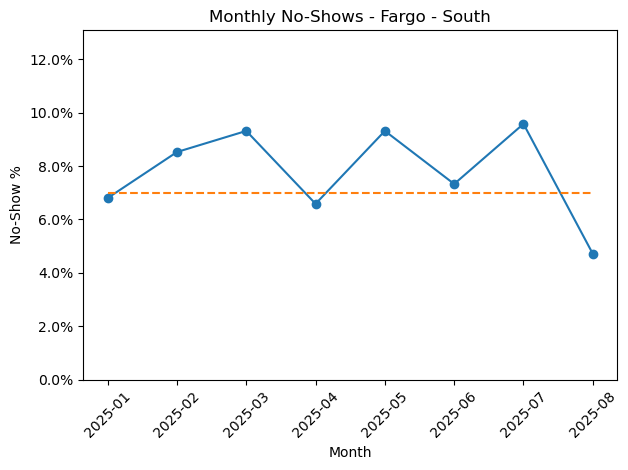

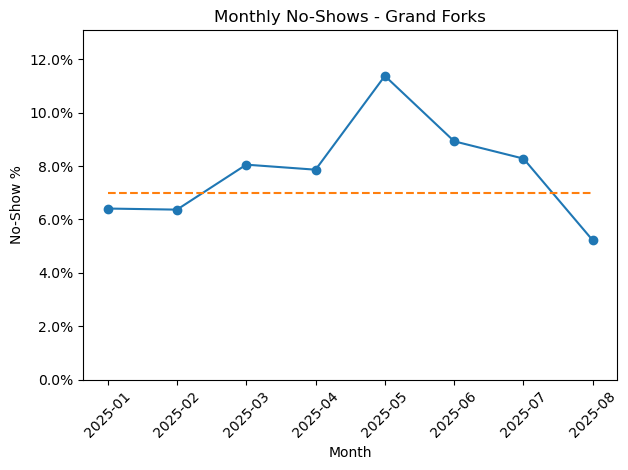

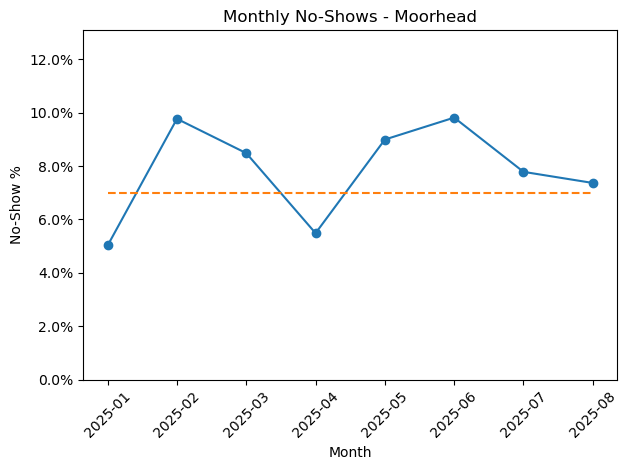

In [113]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

y_max = no_show['no_show'].max()
y_max = float((y_max * 1.15))

for loc in no_show['location'].unique():
    loc_df = (
        no_show[no_show['location'] == loc]
        .sort_values('month')
        .reset_index(drop=True)
    )
    
    plt.figure()
    plt.plot(loc_df['month'], loc_df['no_show'], marker='o')
    plt.plot(kpi_targets['month'], kpi_targets['target_no_show_rate'], linestyle='--')
    plt.title(f'Monthly No-Shows - {loc}')
    plt.xlabel('Month')
    plt.ylabel('No-Show %')
    plt.xticks(rotation=45)
    plt.ylim(0, y_max)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.tight_layout()
    plt.show()

## 2) Workflow Audit: Charge Lag

In [85]:
encounters.head()

,encounter_id,encounter_datetime,patient_id,clinician_id,location,service_code,duration_min,status,enc_date,month
0,100001,2025-02-13 05:40:00,313,5,Fargo - South,H0031,45,Completed,2025-02-13,2025-02
1,100002,2025-01-10 17:07:00,595,19,Fargo - Main,90791,30,Completed,2025-01-10,2025-01
2,100003,2025-04-17 19:27:00,12,21,Fargo - Main,90837,45,Completed,2025-04-17,2025-04
3,100004,2025-04-06 02:33:00,517,25,Fargo - Main,90834,60,Completed,2025-04-06,2025-04
4,100005,2025-03-28 16:28:00,318,18,Fargo - South,90834,60,Completed,2025-03-28,2025-03


In [86]:
# Making a subset dataframe of encounters
enc_subset = encounters[['enc_date','encounter_id', 'patient_id', 'clinician_id', 'location']]

enc_subset.head()

,enc_date,encounter_id,patient_id,clinician_id,location
0,2025-02-13,100001,313,5,Fargo - South
1,2025-01-10,100002,595,19,Fargo - Main
2,2025-04-17,100003,12,21,Fargo - Main
3,2025-04-06,100004,517,25,Fargo - Main
4,2025-03-28,100005,318,18,Fargo - South


In [87]:
billing_enc_merge = billing.merge(enc_subset, how='left', on='encounter_id')
billing_enc_merge.head()

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason,month,enc_date,patient_id,clinician_id,location
0,100001,130.0,2025-02-13,Medicaid,95.32,92.34,16.0,False,NaN,2025-02,2025-02-13,313,5,Fargo - South
1,100002,250.0,2025-01-10,Medicaid,199.54,194.33,21.0,False,NaN,2025-01,2025-01-10,595,19,Fargo - Main
2,100003,200.0,2025-04-22,Sanford,160.28,141.25,25.0,False,NaN,2025-04,2025-04-17,12,21,Fargo - Main
3,100004,160.0,2025-04-10,Medicare,141.37,126.17,24.0,False,NaN,2025-04,2025-04-06,517,25,Fargo - Main
4,100005,160.0,2025-03-28,Sanford,135.16,121.88,38.0,False,NaN,2025-03,2025-03-28,318,18,Fargo - South


In [88]:
billing_enc_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3896 entries, 0 to 3895
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   encounter_id     3896 non-null   int64         
 1   charge_amount    3896 non-null   float64       
 2   submitted_date   3896 non-null   datetime64[ns]
 3   payer            3896 non-null   object        
 4   allowed_amount   3896 non-null   float64       
 5   paid_amount      3607 non-null   float64       
 6   days_to_payment  3607 non-null   float64       
 7   denied_flag      3896 non-null   bool          
 8   denial_reason    266 non-null    object        
 9   month            3896 non-null   object        
 10  enc_date         3896 non-null   datetime64[ns]
 11  patient_id       3896 non-null   int64         
 12  clinician_id     3896 non-null   int64         
 13  location         3896 non-null   object        
dtypes: bool(1), datetime64[ns](2), float64(4

In [89]:
billing_enc_merge['charge_lag_days'] =  (pd.to_datetime(billing_enc_merge['submitted_date']) - pd.to_datetime(billing_enc_merge['enc_date'])).dt.days

billing_enc_merge.head()

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason,month,enc_date,patient_id,clinician_id,location,charge_lag_days
0,100001,130.0,2025-02-13,Medicaid,95.32,92.34,16.0,False,NaN,2025-02,2025-02-13,313,5,Fargo - South,0
1,100002,250.0,2025-01-10,Medicaid,199.54,194.33,21.0,False,NaN,2025-01,2025-01-10,595,19,Fargo - Main,0
2,100003,200.0,2025-04-22,Sanford,160.28,141.25,25.0,False,NaN,2025-04,2025-04-17,12,21,Fargo - Main,5
3,100004,160.0,2025-04-10,Medicare,141.37,126.17,24.0,False,NaN,2025-04,2025-04-06,517,25,Fargo - Main,4
4,100005,160.0,2025-03-28,Sanford,135.16,121.88,38.0,False,NaN,2025-03,2025-03-28,318,18,Fargo - South,0


In [90]:
# charge lag by month
charge_lag_month =  billing_enc_merge.groupby('month', as_index=False)['charge_lag_days'].mean().round(2)

charge_lag_month

,month,charge_lag_days
0,2025-01,2.05
1,2025-02,2.12
2,2025-03,1.95
3,2025-04,2.12
4,2025-05,2.19
5,2025-06,2.15
6,2025-07,2.10
7,2025-08,2.36


In [91]:
# charge lag by clinican
billing_enc_merge.groupby('clinician_id', as_index=False)['charge_lag_days'].mean().round(2)

,clinician_id,charge_lag_days
0,1,2.00
1,2,2.35
2,3,1.79
3,4,2.19
4,5,1.83
5,6,2.38
6,7,2.16
7,8,2.32
8,9,2.21
9,10,2.14


## Revenue Cycle KPI's

In [92]:
billing

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason,month
0,100001,130.0,2025-02-13,Medicaid,95.32,92.34,16.0,False,NaN,2025-02
1,100002,250.0,2025-01-10,Medicaid,199.54,194.33,21.0,False,NaN,2025-01
2,100003,200.0,2025-04-22,Sanford,160.28,141.25,25.0,False,NaN,2025-04
3,100004,160.0,2025-04-10,Medicare,141.37,126.17,24.0,False,NaN,2025-04
4,100005,160.0,2025-03-28,Sanford,135.16,121.88,38.0,False,NaN,2025-03
...,...,...,...,...,...,...,...,...,...,...
3891,104995,200.0,2025-04-21,Medicaid,176.92,150.43,23.0,False,NaN,2025-04
3892,104996,160.0,2025-06-27,Sanford,103.36,91.32,5.0,False,NaN,2025-06
3893,104997,160.0,2025-03-13,BCBS,118.04,112.74,27.0,False,NaN,2025-03
3894,104999,200.0,2025-02-20,Medicaid,146.50,142.58,45.0,False,NaN,2025-02


In [117]:
billing_by_month = billing.groupby('month', as_index=False)['paid_amount'].sum()

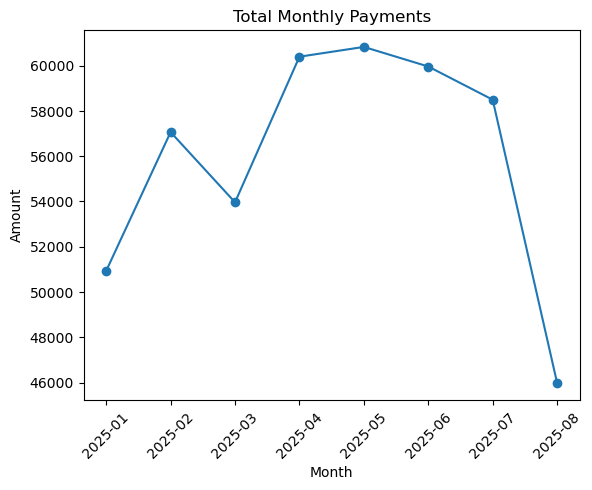

In [126]:
plt.figure()
plt.plot(billing_by_month['month'], billing_by_month['paid_amount'], marker='o')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.title('Total Monthly Payments')
plt.show();

In [152]:
billing_by_location.groupby('month')['paid_amount'].count()

month
2025-01    412
2025-02    448
2025-03    437
2025-04    496
2025-05    489
2025-06    478
2025-07    472
2025-08    375
Name: paid_amount, dtype: int64

In [149]:
billing_by_month = billing.merge(enc_subset, how='left', on='encounter_id').groupby(['month', 'location'], as_index=False)['paid_amount'].sum().round(2)
billing_by_month.head()

,month,location,paid_amount
0,2025-01,Fargo - Main,11950.23
1,2025-01,Fargo - South,10971.89
2,2025-01,Grand Forks,13651.49
3,2025-01,Moorhead,14359.72
4,2025-02,Fargo - Main,15688.75


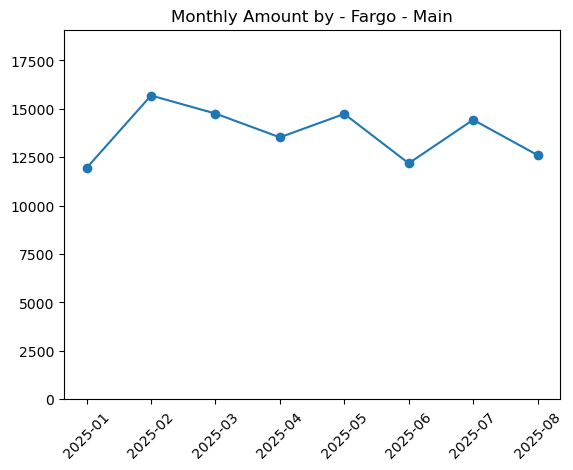

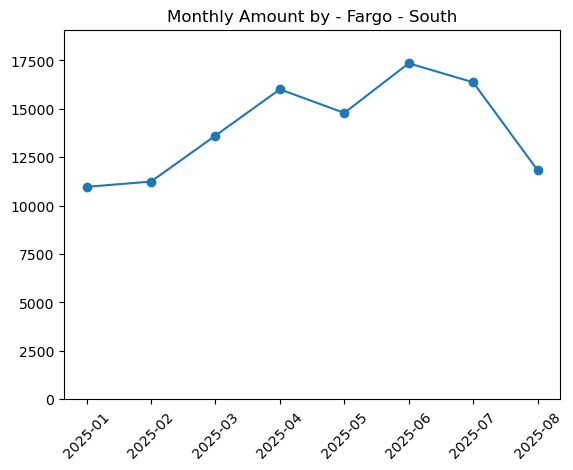

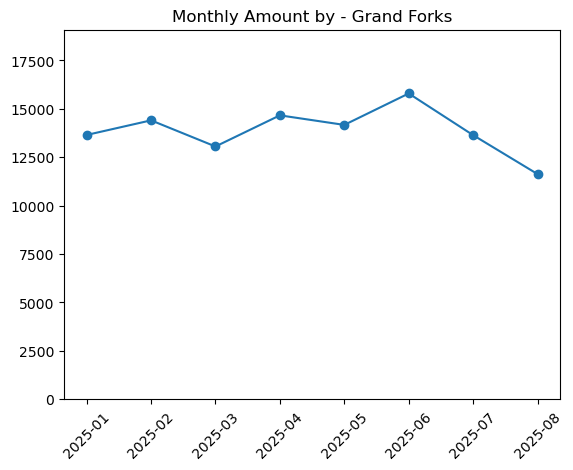

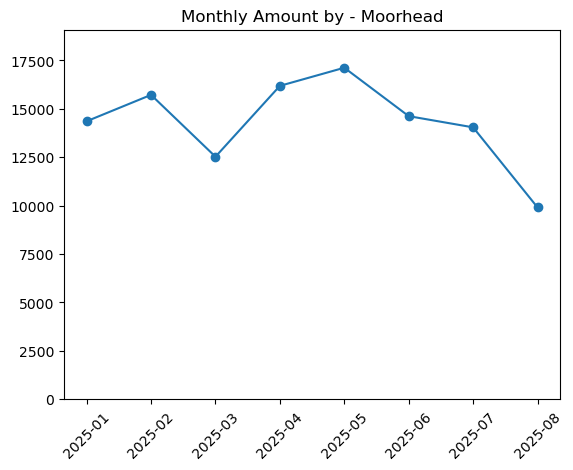

In [150]:
y_max = billing_by_month['paid_amount'].max() * 1.1

for location, grp in billing_by_month.groupby('location'):
    grp = grp.sort_values('month')
    x = grp['month']
    y = grp['paid_amount']
    
    plt.figure()
    plt.plot(x, y, marker='o', label=location)
    plt.title(f"Monthly Amount by - {location}")
    plt.ylim(0, y_max)
    plt.xticks(rotation=45)
    

In [93]:
kpi_targets

,month,target_no_show_rate,target_clean_claim_rate,target_dso_days,target_charge_lag_days,target_denial_rate
0,2025-01,0.07,0.9,35,3,0.06
1,2025-02,0.07,0.9,35,3,0.06
2,2025-03,0.07,0.9,35,3,0.06
3,2025-04,0.07,0.9,35,3,0.06
4,2025-05,0.07,0.9,35,3,0.06
5,2025-06,0.07,0.9,35,3,0.06
6,2025-07,0.07,0.9,35,3,0.06
7,2025-08,0.07,0.9,35,3,0.06


In [94]:
# copying billing dataframe
billing2 = billing_enc_merge.copy()

In [95]:
billing2.head()

,encounter_id,charge_amount,submitted_date,payer,allowed_amount,paid_amount,days_to_payment,denied_flag,denial_reason,month,enc_date,patient_id,clinician_id,location,charge_lag_days
0,100001,130.0,2025-02-13,Medicaid,95.32,92.34,16.0,False,NaN,2025-02,2025-02-13,313,5,Fargo - South,0
1,100002,250.0,2025-01-10,Medicaid,199.54,194.33,21.0,False,NaN,2025-01,2025-01-10,595,19,Fargo - Main,0
2,100003,200.0,2025-04-22,Sanford,160.28,141.25,25.0,False,NaN,2025-04,2025-04-17,12,21,Fargo - Main,5
3,100004,160.0,2025-04-10,Medicare,141.37,126.17,24.0,False,NaN,2025-04,2025-04-06,517,25,Fargo - Main,4
4,100005,160.0,2025-03-28,Sanford,135.16,121.88,38.0,False,NaN,2025-03,2025-03-28,318,18,Fargo - South,0


In [96]:
billing2['is_clean'] = (~billing['denied_flag']).astype(int)
billing2['is_denied'] = billing['denied_flag'].astype(int)
billing2['is_paid'] = billing['paid_amount'].notna().astype(int)
billing2['net_collection_pct'] = billing2['paid_amount'] / billing2['allowed_amount']


kpis = (billing2.groupby('month', as_index=False)
           .agg(
               clean_claim_rate=('is_clean', 'mean'),
               dso_days = ('days_to_payment', 'mean'),
               denial_rate = ('is_denied', 'mean'),
               net_collection_pct = ('net_collection_pct', 'mean'),
               avg_charge_lag = ('charge_lag_days', 'mean')
           )
       )

kpis = kpis.merge(kpi_targets, on='month', how='left')

kpis.head()

,month,clean_claim_rate,dso_days,denial_rate,net_collection_pct,avg_charge_lag,target_no_show_rate,target_clean_claim_rate,target_dso_days,target_charge_lag_days,target_denial_rate
0,2025-01,0.927928,28.104369,0.072072,0.927521,2.049550,0.07,0.9,35,3,0.06
1,2025-02,0.925620,28.256696,0.074380,0.923593,2.121901,0.07,0.9,35,3,0.06
2,2025-03,0.921941,28.050343,0.078059,0.923970,1.953586,0.07,0.9,35,3,0.06
3,2025-04,0.927103,27.526210,0.072897,0.923812,2.117757,0.07,0.9,35,3,0.06
4,2025-05,0.927894,28.274029,0.072106,0.922595,2.189753,0.07,0.9,35,3,0.06


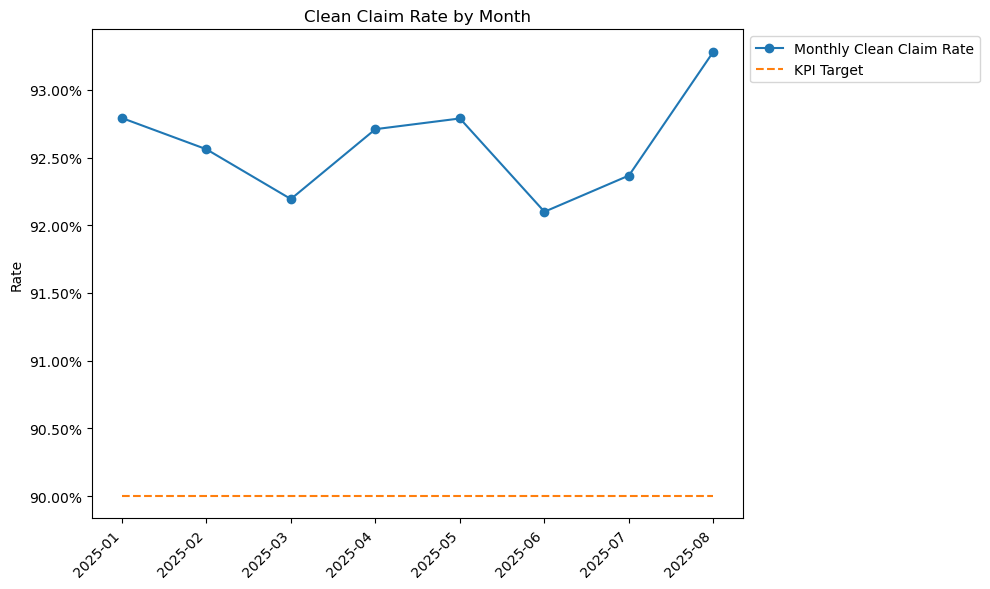

In [97]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10,6));

plt.plot(kpis['month'], kpis['clean_claim_rate'], marker='o', label='Monthly Clean Claim Rate'); 
plt.plot(kpi_targets['target_clean_claim_rate'], linestyle='--', label='KPI Target')


plt.xticks(rotation=45, ha='right'); 
plt.title('Clean Claim Rate by Month');
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=(1.0)))
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Rate'); 
plt.tight_layout()
plt.show()

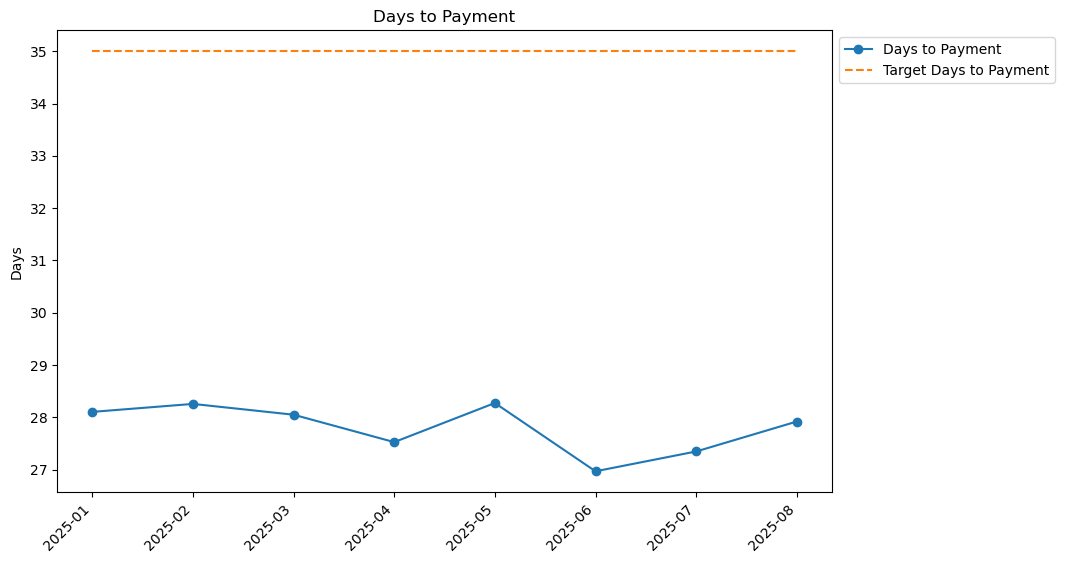

In [98]:
plt.figure(figsize=(10,6));

plt.plot(kpis['month'], kpis['dso_days'], label='Days to Payment', marker='o');
plt.plot(kpi_targets['target_dso_days'], label='Target Days to Payment', linestyle='--');
plt.xticks(rotation=45, ha='right');
plt.title('Days to Payment')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Days')
plt.show();


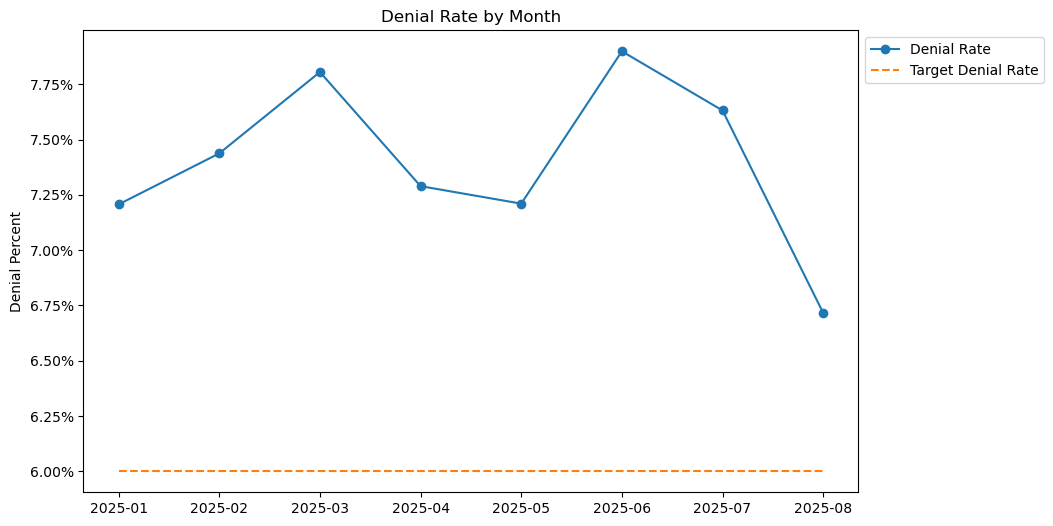

In [99]:
plt.figure(figsize=(10,6));
plt.plot(kpis['month'], kpis['denial_rate'], marker='o', label='Denial Rate');
plt.plot(kpis['target_denial_rate'], linestyle='--', label='Target Denial Rate');

plt.legend(bbox_to_anchor=(1,1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=(1.0)))
plt.title('Denial Rate by Month');
plt.ylabel('Denial Percent');
plt.show();

In [100]:
billing2.groupby('payer')['is_denied'].mean()

payer
BCBS                0.084076
Medicaid            0.078947
Medicare            0.065882
Other Commercial    0.067769
Sanford             0.077748
Self-Pay            0.048544
Name: is_denied, dtype: float64

In [102]:
results = []

months = sorted(billing2['month'].unique())

for m in months:
    sub = billing2[billing2['month'] == m]
    per_payer = sub.groupby('payer')['is_denied'].mean().reset_index()
    per_payer['month'] = m
    results.append(per_payer)
    
denial_by_month = pd.concat(results, ignore_index=True)

denial_by_month


,payer,is_denied,month
0,BCBS,0.054945,2025-01
1,Medicaid,0.042735,2025-01
2,Medicare,0.119048,2025-01
3,Other Commercial,0.062500,2025-01
4,Sanford,0.112245,2025-01
5,Self-Pay,0.062500,2025-01
6,BCBS,0.054545,2025-02
7,Medicaid,0.119048,2025-02
8,Medicare,0.094340,2025-02
9,Other Commercial,0.062500,2025-02


## Graphing the denial rate by payer

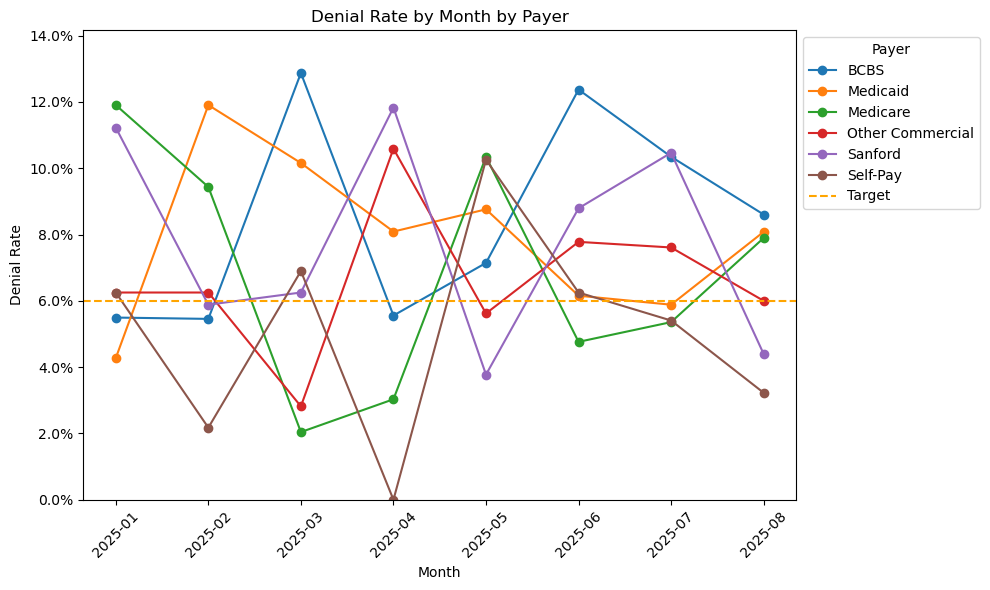

In [103]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

target_rate = 0.06

# making a consistant y-axis
ymax = denial_by_month['is_denied'].max() *1.1

plt.figure(figsize=(10,6))

for payer, grp in denial_by_month.groupby('payer'):
    plt.plot(grp['month'], grp['is_denied'], marker='o', label=payer)
    
plt.plot()    
plt.title('Denial Rate by Month by Payer');
plt.xlabel('Month');
plt.ylabel('Denial Rate');
plt.axhline(y=target_rate, color='orange', linestyle='--', label='Target')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation=45);
plt.ylim(0, ymax)
plt.legend(title='Payer', bbox_to_anchor=(1,1));
plt.tight_layout();
plt.show();



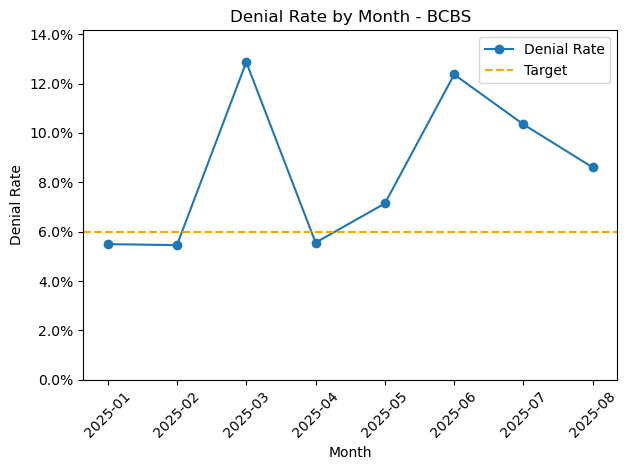

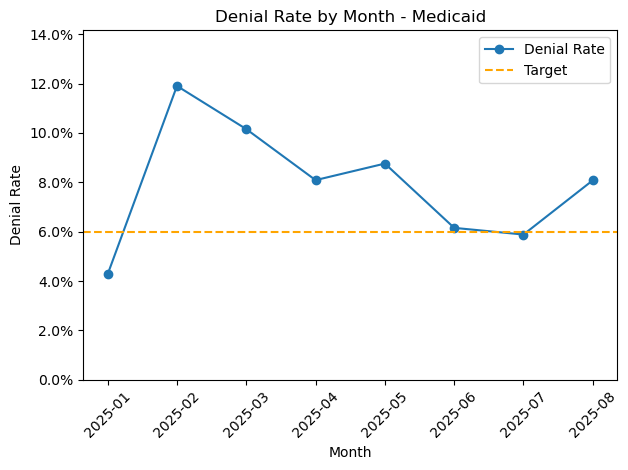

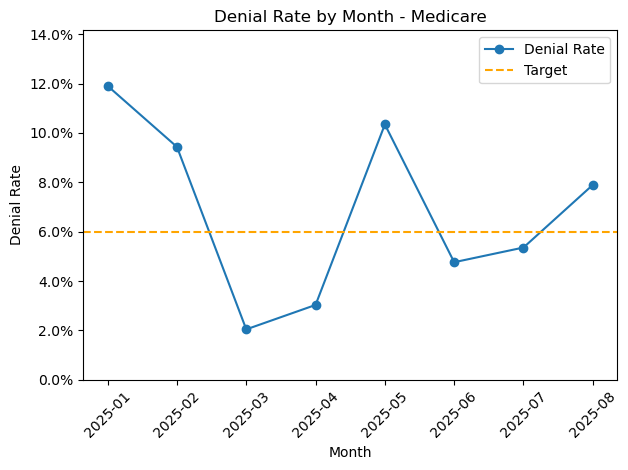

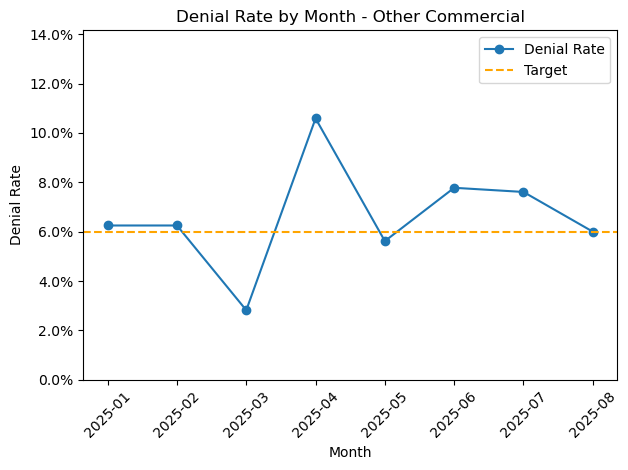

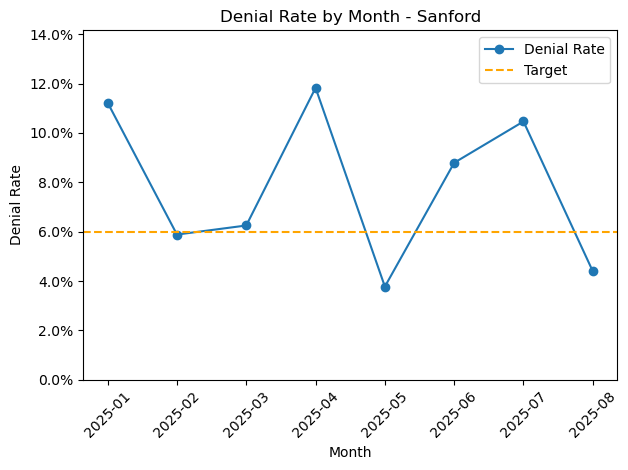

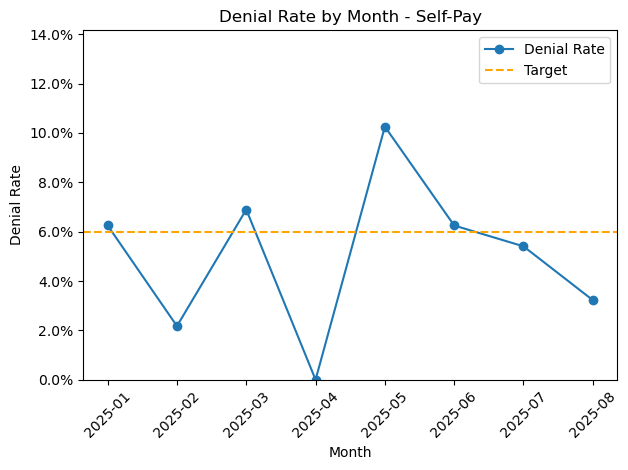

In [104]:
# ploting each payer individually

# making a consistant y-axis
ymax = denial_by_month['is_denied'].max() *1.1

for payer, grp in denial_by_month.groupby('payer'):
    grp = grp.sort_values('month')
    x = grp['month']
    y = grp['is_denied']
    

    plt.plot(x, y, marker='o', label='Denial Rate')
    plt.axhline(y=target_rate, linestyle='--', color='orange', label='Target')
    
    plt.title(f"Denial Rate by Month - {payer}")
    plt.xlabel('Month')
    plt.ylabel('Denial Rate')
    plt.ylim(0, ymax)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show();

In [107]:
billing_subset = billing2[['encounter_id', 'charge_amount', 'denied_flag', 'is_denied']]

In [108]:
billing_encounters_merge = encounters.merge(billing_subset, how='left', on='encounter_id')

billing_encounters_merge.head()

,encounter_id,encounter_datetime,patient_id,clinician_id,location,service_code,duration_min,status,enc_date,month,charge_amount,denied_flag,is_denied
0,100001,2025-02-13 05:40:00,313,5,Fargo - South,H0031,45,Completed,2025-02-13,2025-02,130.0,False,0.0
1,100002,2025-01-10 17:07:00,595,19,Fargo - Main,90791,30,Completed,2025-01-10,2025-01,250.0,False,0.0
2,100003,2025-04-17 19:27:00,12,21,Fargo - Main,90837,45,Completed,2025-04-17,2025-04,200.0,False,0.0
3,100004,2025-04-06 02:33:00,517,25,Fargo - Main,90834,60,Completed,2025-04-06,2025-04,160.0,False,0.0
4,100005,2025-03-28 16:28:00,318,18,Fargo - South,90834,60,Completed,2025-03-28,2025-03,160.0,False,0.0


In [109]:
# denial rate by service code
service_code = (billing_encounters_merge
    .groupby(['month', 'service_code'], as_index=False)['is_denied']
    .mean()
    .rename(columns={'is_denied': 'denial rate'})
    .sort_values(['month', 'service_code'])
)

service_code.head()

,month,service_code,denial rate
0,2025-01,90791,0.035714
1,2025-01,90834,0.073034
2,2025-01,90837,0.091429
3,2025-01,90853,0.115385
4,2025-01,H0031,0.018868


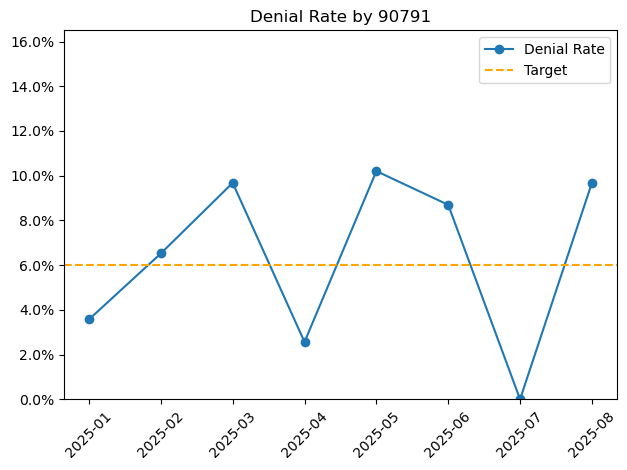

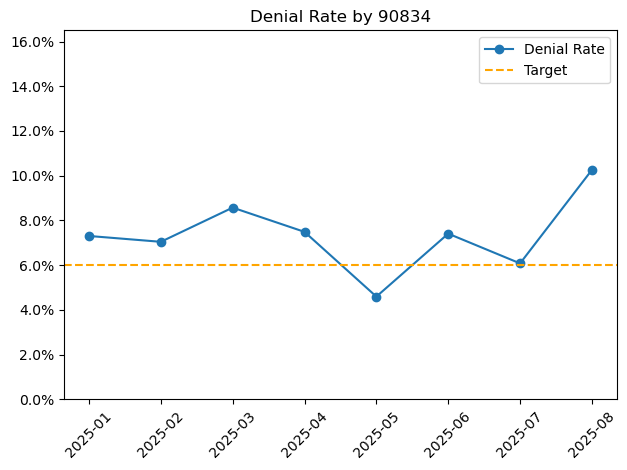

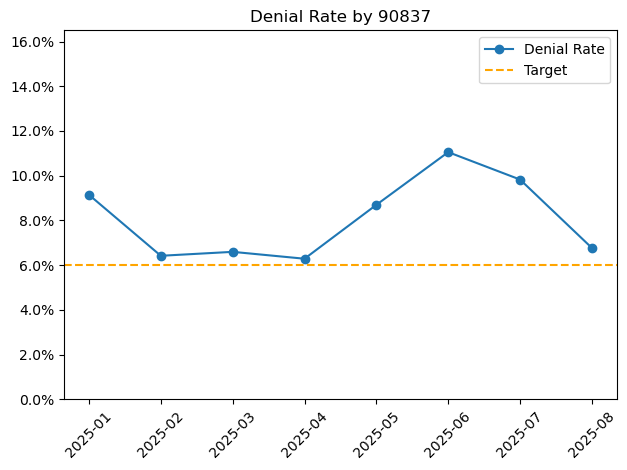

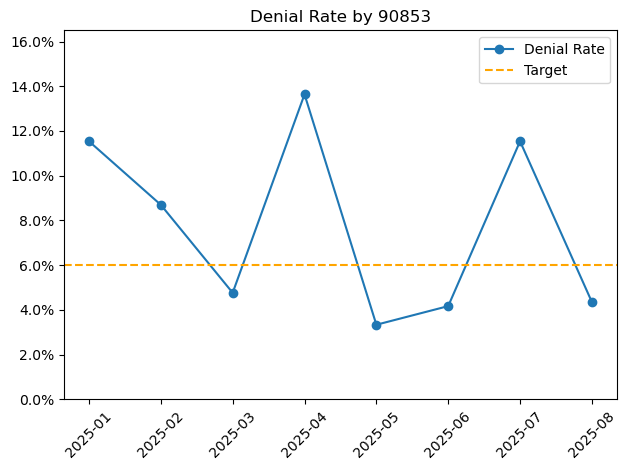

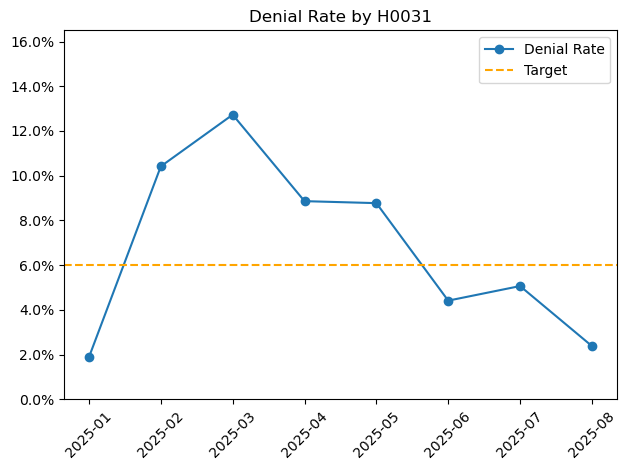

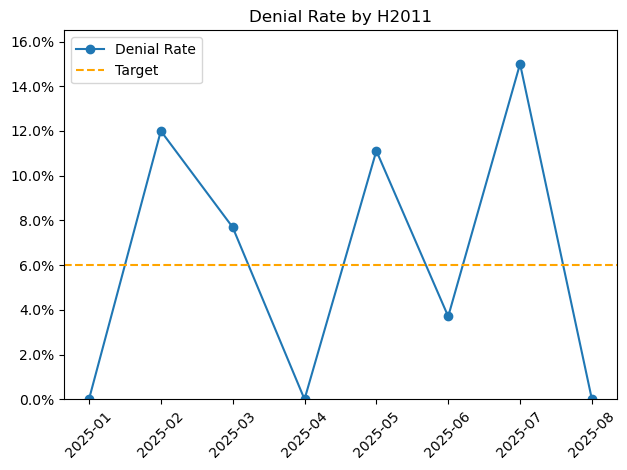

In [110]:
# plotting by service code by month

target_max = float(service_code['denial rate'].max() * 1.1)

for code, grp in service_code.groupby('service_code'):
    x = grp['month']
    y = grp['denial rate']
    
    
    plt.plot(x, y, marker='o', label='Denial Rate')
    plt.axhline(y=target_rate, linestyle='--', color='orange', label='Target')
    plt.title(f"Denial Rate by {code}")
    plt.xticks(rotation=45)
    plt.ylim(0, target_max)
    plt.legend()
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    plt.tight_layout()
    plt.show();